In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
from scipy import optimize

from tyssue.core.sheet import Sheet

from tyssue.utils.utils import set_data_columns

import tyssue.geometry.sheet_geometry as geom
import tyssue.dynamics.sheet_vertex_model as model
import tyssue.solvers.sheet_vertex_solver as solver

from tyssue.dynamics.sheet_isotropic_model import isotropic_relax



from tyssue.draw.mpl_draw import sheet_view
import tyssue.draw.mpl_draw as draw
from tyssue.io import hdf5

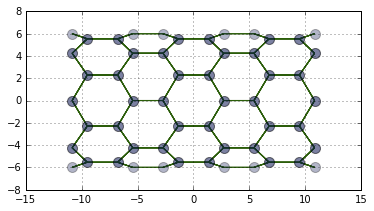

In [3]:
h5store = 'small_hexagonal.hf5'
datasets = hdf5.load_datasets(h5store, data_names=['face', 'jv', 'je'])
sheet = Sheet('emin', datasets)

sheet.set_geom(geom)
geom.update_all(sheet)

mod_specs, dim_mod_specs = sheet.set_model(model)
sheet.grad_norm_factor = dim_mod_specs['settings']['grad_norm_factor']
sheet.nrj_norm_factor = dim_mod_specs['settings']['nrj_norm_factor']

isotropic_relax(sheet, **mod_specs)

fig, ax = sheet_view(sheet, ['z', 'x'])

In [4]:
live_je = sheet.upcast_face(sheet.face_df.is_alive).astype(np.bool)
active_jvs = sheet.je_df[live_je].srce.unique()


sheet.jv_df.loc[active_jvs, 'is_active'] = 1

In [5]:
from tyssue.topology.sheet_topology import type1_transition

ImportError: No module named 'tyssue.topology'

![Type 1 transition](../../doc/illus/t1_transition.png)

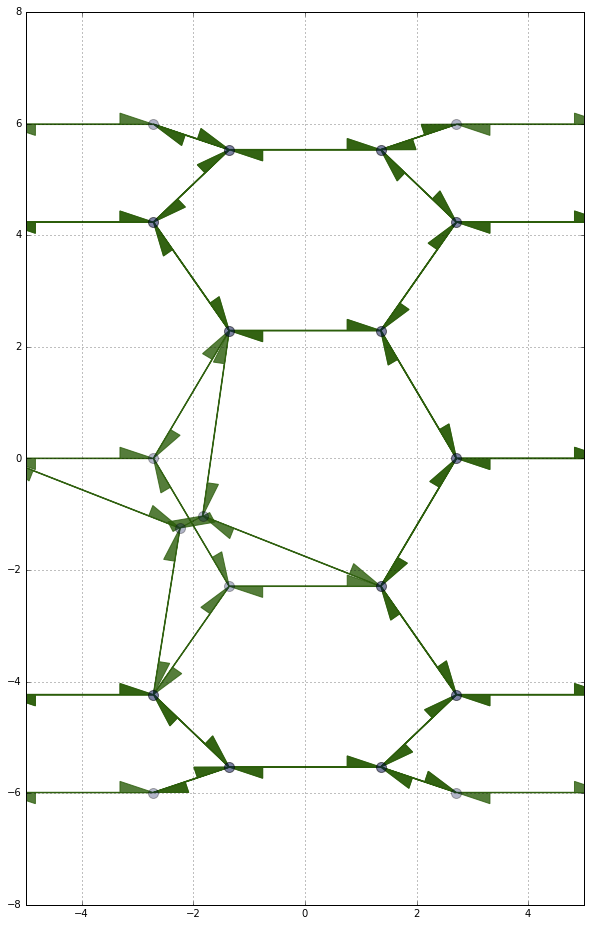

In [109]:
draw_specs = {
    "je": {
        'visible': True,
        'width': 0.01,
        'head_width': 0.4,
        'length_includes_head': True,
        'shape': 'right',
        'color': '#2b5d0a',
        'alpha': 0.8,
        'zorder': 1
        },
    "jv": {
        'visible': True,
        's': 100,
        'c': '#000a4b',
        'alpha': 0.3,
        'zorder': 2,
        },
    'grad': {
        'color':'b',
        'alpha':0.5,
        'width':0.04,
        },
    "face": {
        'visible': False,
        'color':'#8aa678',
        'alpha': 1,
        'zorder': -1,
        }
    }



fig, ax = sheet_view(sheet, ['z', 'x'], **draw_specs)

ax.set_xlim(-5, 5)


ax.set_aspect('equal')
fig.set_size_inches(16, 16)


True


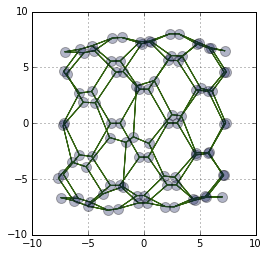

In [111]:
settings = {
    'minimize': {
        'options': {'disp':True,
        'gtol':1e-4},
        'jac': solver.opt_grad
        }
    }


res = solver.find_energy_min(sheet, geom, model, **settings)
print(res['success'])
fig, ax = sheet_view(sheet, ['z', 'x'])